# DATA832 - Classification de pays selon le niveau d'aide nécessaire
## Auteurs : HENRIQUES DOS SANTOS Joaquim & WALLERAND Alex

Dans ce projet, nous disposons d'un dataset contenant 10 colonnes, qui présente des informations sur une centaine de pays. Comme par exemple, le PIB par habitant, l'inflation, ou encore le revenu moyen des habitants. Le but est ainsi de catégoriser ces pays en 3 classe : pas d'aide, peut avoir besoin d'aide, à besoin d'aide. Pour cela, comme nos données ne sont pas étiquetés, nous allons devoir faire de l'apprentissage non supervisé, notamment du clustering, afin de trouver des regroupements de pays pour finalement former ces classes.

## Table des matières
1. [Lecture et Visualisation des données](#1-lecture-et-visualisation-des-données)
    - Affichage des premiers éléments
    - Calcul de la matrice de corrélation
    - Affichage des distributions de chaque variable par pays
2. [Calculs de modèles](#2-calculs-de-modèles)
    - Réduction de dimension : ACP
    - Kmeans Clustering
    - Spectral Clustering
3. [Visualisation et interprétation des résultats](#3-visualisation-et-interprétation-des-résultats)

## Import des librairies

In [37]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import numpy as np

## 1. Lecture et Visualisation des données

Dans cette partie, nous allons dans un premier temps analyser, à l'aide de visualisations et de différents calculs, les variables de notre dataset. Cela va nous permettre de tirer des informations afin de dire ou non si certaines variables sont utiles pour les modèles que nous allons développer plus tard.

### Affichage des premiers éléments

In [38]:
data = pd.read_csv("Country-data.csv")
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


### Calcul de la matrice de corrélation

Nous calculons la matrice de corrélaiton des features de notre dataset, pour pouvoir interpréter les relations entre chacune d'elles

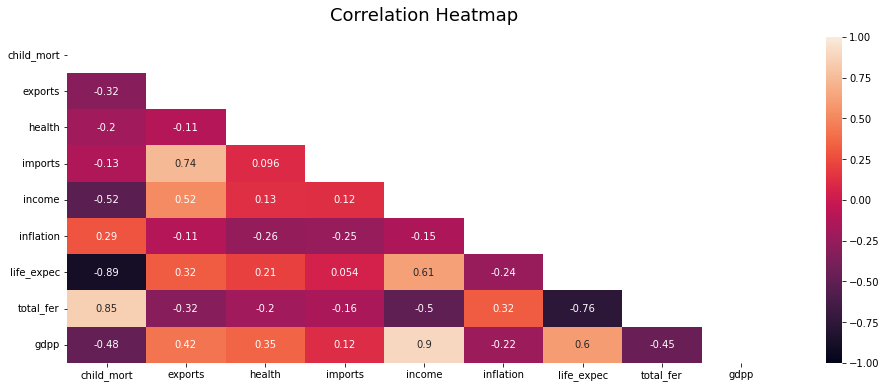

In [39]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(data.corr(), dtype = bool)) # define a mask to set the values in the upper triangle to True
heatmap = sns.heatmap(data.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
plt.show()

On observe qu'il y a de nombreuses corrélations évidentes, comme par exemple le nombre de morts d'enfants avec l'espérance de vie, ou encore le PIB avec le revenu moyen. Il y a cependant des variables très peu corrélées avec les autres comme l'inflation ou la santé. Nous pouvons ainsi remettre en question l'utilité de ces dernières. Cependant, il faut encore observer leur distribution, afin de voir si on peut observer différentes catégories dans l'ensemble de leurs valeurs. Il faut de plus ne pas oublier qu'en retirant ces variables, on pourrait perdre beaucoup d'informations.

### Affichage des distributions de chaque variable par pays

In [40]:
for column in data.columns[1:]:
    fig = px.histogram(data, x="country", y=column, labels={"country" : "Countries"}, title=f"{column} by countries").update_layout(yaxis_title=column)
    fig.show()

On définit maintenant une fonction qui permet d'afficher la distribution des valeurs pour une variable donnée, pour un nombre n de pays, dans l'ordre croissant ou décroissant.

In [41]:
def histo(name_column, n ,ascending):
    sorted = data.sort_values(by=name_column,ascending=ascending)
    sorted10 = sorted.head(n)

    fig = px.histogram(sorted10, x="country", y=name_column, labels={"country" : "Countries"}, title=f"{name_column} by countries").update_layout(yaxis_title=name_column)
    fig.show()

histo("gdpp", 15, True)
histo("child_mort", 15, False)

## 2. Calculs de modèles

Nous allons maintenant calculer plusieurs modèles dans le but de faire ressortir nos clusters de pays. Nous allons ainsi tenter plusieurs, en voyant tout d'abord si nous devons considérer une méthode de réduction de dimension, puis en normalisant nos données.

### Réduction de dimension : ACP

Les méthodes de réduction de dimensions sont utiles lorsque le dataset comprend de nombreuses. Dans notre cas nous avons 9 features, ce qui n'est pas forcément beaucoup. C'est pourquoi nous allons maintenant remettre en cause l'utilité de ce type de méthode pour notre jeu de données, dans le cas de l'ACP.

Nous avons créé un pipeline qui comprend d'abord un transformateur StandardScaler, pour standardiser nos valeurs. Cette transformation est très utile pour les ACP, et nous comptons ensuite l'utiliser pour établir nos modèles. Puis le pipeline se termine avec l'estimateur PCA, qui permet de calculer les composantes principales de nos données. Nous affichons ensuite les composantes principales et leur taux de variance expliqué ainsi que la somme cumulative de cette dernière.

In [42]:
X = data.iloc[:, 1:]
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=9))])
pipe.fit(X)

exp_var_pca = pipe.named_steps['pca'].explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
fig = px.line(x=np.arange(1, len(exp_var_pca)+1),
              y=cum_sum_eigenvalues, line_shape='hv',
              title='PCA explained variance',
              labels={'x' : 'Principal Component index', 'y' : 'Explained variance ration'}
              )
fig.add_bar(x=np.arange(1, len(exp_var_pca)+1), 
           y=exp_var_pca,
           marker=dict(color='blue'),
           name='Individual explained variance'
           )
fig.show()

Nous pouvons voir que la première composante principale explique environ 45% de la variance, et la seconde 17%, ce qui cumulé nous donne une variance de 63%. Ainsi, si l'on décide de choisir ces 2 composante, c'est un résultat correct, mais cela veut dire que l'on perd quand même 37% de l'information, ce qui est non négligeable sur 9 features.
Nous faisons alors le choix de garder nos 9 variables par la suite et de ne pas utiliser de réduction de dimension.

### Kmeans Clustering

Dans un premier temps, nous allons tenter de trouver le K optimal, c'est à dire le nombre de clusters, pour notre modèle de Kmeans en utilisant la méthode du coude. Pour chaque K allant de 1 à 9, nous allons afficher l'inertie du modèle calculé, c'est à dire la somme des distances au carré de chaque échantillon, par rapport à son centroid le plus proche. Il faut ensuite observer le graphe obtenue pour extraire le point d'inflexion dans la zone de coude, qui donne le K optimal.

In [43]:
X = data.iloc[:, 1:]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
k_range = range(1, 10)
for k in k_range:
    model = KMeans(n_clusters=k, random_state=0).fit(X_scaled)
    inertia.append(model.inertia_)

fig = px.line(x=k_range, y=inertia, title="Elbow Method", labels={'x' : 'Number of clusters K', 'y' : 'Inertia'})
fig.show()

Avec le graphe précédent, on peut observer que le K optimal semble être 4. Le problème qui se pose est que nous voulons ressortir de notre modèle, trois classes de pays, différentes. On peut alors se poser la question si avec un Kmeans, il serait plus intéressant de créer une nouvelle classe de pays à déterminer, en fonction de la distribution des valeurs de cette dernière. Néanmoins, par soucis de simplicité, nous allons prendre un nombre de cluster égal à 3, car nous verrons par la suite qu'il permet de sortir des résultats attendus.

Nous pouvons ainsi maintenant calculer notre Kmeans, en créant un pipe qui d'abord standardise les valeurs, puis calcule le modèle.

In [44]:
pipe = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=3, random_state=0))])
pipe.fit(X)

X_scaled = pipe.named_steps['scaler'].transform(X)
kmeans_labels = pipe.named_steps['kmeans'].labels_
centroids = pipe.named_steps['kmeans'].cluster_centers_

fig= px.scatter(X_scaled, x=X_scaled[:, 0], y=X_scaled[:, -1],  color=kmeans_labels.astype(str), title='Cluster Visualization on Scaled Data', labels={'x' : 'Child deaths', 'y' : 'GDPP', 'color' : 'Class'})
fig.add_scatter(x=centroids[:, 0], y=centroids[:, -1], mode='markers', marker_color='black', marker_size=8, name='centroid')
fig.show()


Nous pouvons ainsi observer les 3 clusters distincts et leurs centroids respectifs, sur le graphe précédent qui prend pour dimension le nombre de morts d'enfants par rapport au PIB. On observe qu'il y a quelques échantillons des classes 0 et 1 qui se mélangent, et donc que nos clusters ne sont pas bien distincts. Il faudrait vérifier avec toutes les autres dimensions si le même constat peut être fait. Pour finalement mesurer si le clustering est correcte, nous pourrions utiliser le silouhette score.

### Spectral Clustering

Nous allons maintenant tester le Spectral Clustering sur notre dataset, dans le but de potentiellement trouver un meilleur modèle que le Kmeans. Pour cela, nous décidons d'utiliser le transformateur MinMaxScaler pour nos données, avant de les passer au modèle spectral. Nous allons tenter différents hyperparamètres permettant de modifier la façon dont se comporte cet algorithme.

In [45]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('spectral', SpectralClustering(n_clusters=3, affinity='nearest_neighbors', assign_labels='discretize', random_state=0))
    ])
pipe.fit(X)

X_min_max = pipe.named_steps['scaler'].transform(X)
spectral_labels = pipe.named_steps['spectral'].labels_

fig= px.scatter(X_min_max, 
                x=X_min_max[:, 0], 
                y=X_min_max[:, 1],  
                color=spectral_labels.astype(str), 
                title='Cluster Visualization on Scaled Data', 
                labels={'x' : 'child_mort', 'y' : 'GDPP', 'color' : 'Class'}
                )
fig.show()

On observe que les données de clusters se recoupent comme précédemment, mais un peu plus ici. Notre modèle de Spectral Clustering est donc peut être moins performant que le Kmeans. C'est ce que nous verrons lors de l'analyse des résultats.

## 3. Visualisation et interprétation des résultats

Nous allons maintenant afficher les cartes choropleth pour voir quels pays appartiennent à la même classe, puis pour chaque feature un box plot pour observer les moyennes et médiane de chaque cluster. Cela nous permettra ainsi de déterminer quel classe de cluster correspondent aux classes que nous recherchons. 

In [46]:
fig = go.Figure(data=go.Choropleth(
    locations=data['country'],
    locationmode='country names',
    z=kmeans_labels.astype(str),
    colorbar_title = 'Class'
))

fig.update_layout(title_text='Kmeans Country Visualization',
    geo=dict(
        showframe=False,
    ),
    width=1000,
    height=500
)

fig.show()

Au premier coup d'oeil on peut apercevoir les classes que nous cherchons à mettre en évidence. En effet la classe 2 représente les pays qui n'ont pas besoin d'aide, car elle est composé de pays développés européens et des USA. La classe 1, des pays en développement qui ont potentiellement besoin d'aide, et finalement la classe 0 qui sont des pays en développement, principalement en Afrique.

In [47]:
fig = go.Figure(data=go.Choropleth(
    locations=data['country'],
    locationmode='country names',
    z=spectral_labels.astype(str),
    colorbar_title = 'Class'
))

fig.update_layout(title_text='Spectral Country Visualization',
    geo=dict(
        showframe=False,
    ),
    width=1000,
    height=500
)

fig.show()

Ici les couleurs ne sont pas les mêmes pour les classes, puisque le modèle Spectral n'a pas sorti les labels dans le même ordre que le Kmeans. Cependant, on observe la même tendance avec néanmoins des potentiels erreurs, comme par exemple la Corée du Sud qui est un pays développé, et qui à nos connaissance ne nécessiteraient pas forcément de besoin d'aide.

Nous pouvons aisi dire que nous choisissons comme modèle de référence celui calculé par le Kmeans.

In [48]:
data['kmeans_cluster'] = kmeans_labels
data['spectral_cluster'] = spectral_labels

features = data.columns[1:-2]
for column in features:
    fig = px.box(data,
                 x='kmeans_cluster',
                 y=column,
                 color='kmeans_cluster'       
    )
    fig.show()

Nos intuitions sont ainsi confirmés concernant les classes du Kmeans en observant des variables très pertinentes comme celle du PIB.
Nous obtenons finalement les résultats suivants : 
- Classe 2 : pays qui n'ont pas besoin d'aide
- Classe 1 : pays qui ont potentiellement besoin d'aide
- Classe 0 : pays qui ont besoin d'aide

Classe 0 :

In [50]:
data[data['kmeans_cluster'] == 0].head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_cluster,spectral_cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553,0,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530,0,1
17,Benin,111.0,23.8,4.10,37.2,1820,0.885,61.8,5.36,758,0,1
21,Botswana,52.5,43.6,8.30,51.3,13300,8.920,57.1,2.88,6350,0,0
25,Burkina Faso,116.0,19.2,6.74,29.6,1430,6.810,57.9,5.87,575,0,1


Classe 1 :

In [51]:
data[data['kmeans_cluster'] == 1].head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_cluster,spectral_cluster
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1,0
5,Argentina,14.5,18.9,8.10,16.0,18700,20.90,75.8,2.37,10300,1,0
6,Armenia,18.1,20.8,4.40,45.3,6700,7.77,73.3,1.69,3220,1,0


Classe 2 :

In [52]:
data[data['kmeans_cluster'] == 2].head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_cluster,spectral_cluster
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,2,2
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,2,2
11,Bahrain,8.6,69.5,4.97,50.9,41100,7.440,76.0,2.16,20700,2,0
15,Belgium,4.5,76.4,10.70,74.7,41100,1.880,80.0,1.86,44400,2,2
23,Brunei,10.5,67.4,2.84,28.0,80600,16.700,77.1,1.84,35300,2,0
